## Sensitivity Analysis

Some experimentation with local and global sensitivity analysis based on the notebook provided by the course and some articles

#### References
- Broeke, G. ten, Voorn, G. van, Ligtenberg, A. (2016). Which Sensitivity Analysis Method Should I Use for My Agent-Based Model?



### OFAT
One-Factor-At-a-Time: Method of local sensitivity analysis, where one input parameter is varied and the others are kept fixed. According to ten Broeke (2016) a pre-test needs to be done to ensure a the model converges to a steady state behaviour. This might prove problematic for our model, since we examine early stage colonies, and in the results from the ODE model, the ant and fungus biomass are still increasing vastly. 

In [2]:
from leafcutter_ants_fungi_mutualism.model import LeafcutterAntsFungiMutualismModel, track_ants, track_leaves, track_ratio_foragers
from mesa.batchrunner import BatchRunner, BatchRunnerMP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
"""
Pre-test to determine whether the model converges to a steady state behaviour
"""
model = LeafcutterAntsFungiMutualismModel(num_ants=50, num_plants=30, width=20, height=50,
                 pheromone_lifespan=30, num_plant_leaves=100,
                 leaf_regrowth_rate=1/2, ant_death_probability=0.01,
                 initial_fungus_energy=50, fungus_decay_rate=1/50)

repetitions = 3
time_steps = 100

output_variables = {"Ants_Biomass": track_ants,
                    "Fungus_Biomass": lambda m: m.fungus.biomass,
                    "Ants with Leaves": track_leaves,
                    "Fraction forager ants": track_ratio_foragers,
}

variable_parameters = {'num_ants': [20,50]}

# batch = BatchRunner(LeafcutterAntsFungiMutualismModel,
#                     max_steps = time_steps, 
#                     variable_parameters = variable_parameters,
#                     iterations = repetitions,
#                     model_reporters = output_variables,
#                     display_progress = True)

batch = BatchRunnerMP(LeafcutterAntsFungiMutualismModel, #nr_processes = 8,
                    max_steps = time_steps, 
                    variable_parameters = variable_parameters,
                    iterations = repetitions,
                    model_reporters = output_variables,
                    display_progress = True)

batch.run_all()

data = batch.get_model_vars_dataframe()

print(data)

BatchRunner MP will use 8 processors.


6it [00:04,  1.45it/s]

   num_ants  Run  Ants with Leaves  Ants_Biomass  Fraction forager ants  \
0        20    0                80           916               0.304585   
2        50    0                93          1342               0.248882   
1        20    1                94          1157               0.275713   
4        50    1                85          1194               0.234506   
3        50    2               165          1290               0.425581   
5        20    2               114          1463               0.246070   

   Fungus_Biomass  
0        6.413472  
2        6.491313  
1        6.882433  
4        6.471854  
3        6.613593  
5        6.040320  


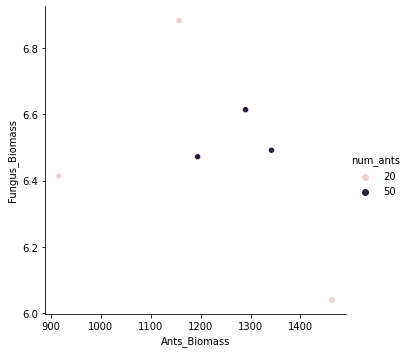

In [7]:
data_collection = batch.get_collector_model()
sns.relplot(data=data, x='Ants_Biomass', y='Fungus_Biomass', hue='num_ants')

odict_keys([(20, 0), (20, 1), (50, 0), (50, 2), (50, 1), (20, 2)])
     Fungus Biomass  Ant Biomass  Ants with Leaves  Fraction forager ants
0         50.000000           20                 0               0.500000
1         50.000000           20                 0               0.500000
2        139.790000           20                 1               0.500000
3        129.106050           34                 2               0.558824
4        116.520520           48                 3               0.541667
..              ...          ...               ...                    ...
96         6.047029         1117               116               0.285586
97         6.016794         1137               117               0.285840
98         6.986710         1118               109               0.283542
99        14.951777         1128               103               0.286348
100        6.917018         1170               104               0.281197

[101 rows x 4 columns]


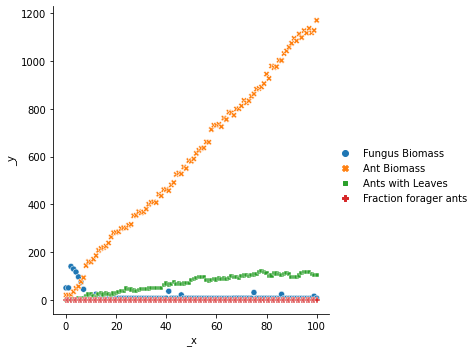

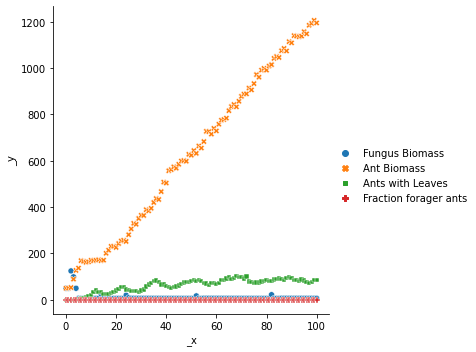

In [9]:
data_collection = batch.get_collector_model()
print(data_collection.keys())

# every key - value pair (nr_ants, repetition_number) contains a single model run
print(data_collection[(20,1)])
sns.relplot(data=data_collection[(20,1)])
sns.relplot(data=data_collection[(50,1)])

In [11]:
""" 
Code based on the sensitivity analysis notebook
"""

# define variables and bounds
# problem is a dictionary, the keys are the variable (parameter) names, 
# the values are a list of the type and bounds
problem = {'num_ants': [int, [1,100]],
           'num_plants': [int, [1,100]], 
           'pheromone_lifespan': [int, [5, 100]],
           'num_plant_leaves': [int, [10, 200]],
           'initial_foragers_ratio': [float, [0.1, 1.0]], 
           'leaf_regrowth_rate': [float, [0.01, 1.0]],
           'ant_death_probability': [float, [0, 0.2]],
           'initial_fungus_energy': [float, [10, 100]],
           'fungus_decay_rate': [float, [0.001, 0.1]], 
           'energy_biomass_cvn': [float, [1, 3]], 
           'fungus_larvae_cvn': [float, [0.5, 1.5]],
           'energy_per_offspring': [float, [1.0, 10]],
           'fungus_feed_threshold': [float, [5.0, 20.0]],
           'max_fitness_queue_size': [int, [1, 100]],
}

# standard parameters:
# num_ants=50, num_plants=30, width=20, height=50,
#                  pheromone_lifespan=30, num_plant_leaves=100,
#                  initial_foragers_ratio=0.5,
#                  leaf_regrowth_rate=1/2, ant_death_probability=0.01,
#                  initial_fungus_energy=50, fungus_decay_rate=0.005,
#                  energy_biomass_cvn=2.0, fungus_larvae_cvn=0.9, energy_per_offspring=1.0,
#                  fungus_biomass_death_threshold=5.0, fungus_feed_threshold=5.0,
#                  max_fitness_queue_size=20)


# define fixed parameters
# fixed_params = {}

# set the repetitions, amount of steps, amount of distinc_samples
repetitions = 5
max_steps = 500
distinct_samples = 10

# set the outputs
model_reporters = {"Ants_Biomass": track_ants,
                "Fungus_Biomass": lambda m: m.fungus.biomass,
                "Fraction forager ants": track_ratio_foragers,
}

data = {}


for var in problem.keys():
    # get the sample for this variable
    samples = np.linspace(*problem[var][1], num=distinct_samples, dtype=problem[var][0])

    
#     print(var, sample, type(sample[2]))
    batch = BatchRunnerMP(LeafcutterAntsFungiMutualismModel, 
                        max_steps=max_steps,
                        iterations=repetitions,
                        variable_parameters={var: samples},
                        model_reporters=model_reporters,
                        display_progress=True)
                        # fixed_parameters = ...

    batch.run_all()

    data[var] = batch.get_model_vars_dataframe()



BatchRunner MP will use 8 processors.


8it [00:48,  6.12s/it]Process ForkPoolWorker-40:
Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Process ForkPoolWorker-34:
Process ForkPoolWorker-37:
Process ForkPoolWorker-35:
Process ForkPoolWorker-38:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/floor/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
 

KeyboardInterrupt
  File "/WIN_D/Shared/Documents/School/Master/AgentBasedModelling/agent-based-modeling-project/leafcutter_ants_fungi_mutualism/ant_agent.py", line 178, in get_nearby_plants_and_pheromones
    neighbors = self.model.grid.get_neighbors(
  File "/WIN_D/Shared/Documents/School/Master/AgentBasedModelling/agent-based-modeling-project/leafcutter_ants_fungi_mutualism/ant_agent.py", line 36, in step
    self.explore_step()
  File "/home/floor/.local/lib/python3.8/site-packages/mesa/space.py", line 325, in get_neighbors
    return list(self.iter_neighbors(pos, moore, include_center, radius))
  File "/WIN_D/Shared/Documents/School/Master/AgentBasedModelling/agent-based-modeling-project/leafcutter_ants_fungi_mutualism/ant_agent.py", line 59, in explore_step
    self.random_move()
  File "/home/floor/.local/lib/python3.8/site-packages/mesa/space.py", line 298, in iter_neighbors
    return self.iter_cell_list_contents(neighborhood)
Process ForkPoolWorker-39:
  File "/WIN_D/Shared/D

KeyboardInterrupt: 

  File "/home/floor/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 2438, in all
    return _wrapreduction(a, np.logical_and, 'all', axis, None, out,
  File "/home/floor/.local/lib/python3.8/site-packages/mesa/space.py", line 51, in wrapper
    return wrapped_function(*args)
  File "/home/floor/anaconda3/lib/python3.8/site-packages/numpy/core/numerictypes.py", line 359, in issubdtype
    @set_module('numpy')
  File "/home/floor/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 71, in _wrapreduction
    passkwargs = {k: v for k, v in kwargs.items()
  File "/home/floor/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 71, in <dictcomp>
    passkwargs = {k: v for k, v in kwargs.items()
  File "/WIN_D/Shared/Documents/School/Master/AgentBasedModelling/agent-based-modeling-project/leafcutter_ants_fungi_mutualism/ant_agent.py", line 232, in get_neighborhood_density
    for agent in self.model.grid.iter_cell_list_contents(cell):

In [77]:
# the following functions are copied directly from the notebook and still need to be adapted
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    repetitions = df.groupby(var)[param].count()
    minimum = df.groupby(var)[param].min()
    maximum = df.groupby(var)[param].max()
    
    stdev = df.groupby(var)[param].std()

    ax.scatter(x, y, c='k', marker='o')
#     ax.plot(x, y, c='k', marker='o', linewidth = 0.8)
#     ax.fill_between(x, y - stdev, y + stdev, color='grey', alpha=0.2)
    ax.vlines(x, y-stdev, y + stdev, color='grey')
    
    
#     ax.plot(x, minimum, c='magenta', marker='x', linewidth = 0.8)
#     ax.plot(x, maximum, c='deepskyblue', marker='+', linewidth = 0.8)
    ax.scatter(x, minimum, c='magenta', marker='x')
    ax.scatter(x, maximum, c='deepskyblue', marker='+')

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(data, model_reporters):
    """
    
    """

    fig, axs = plt.subplots(len(data.keys()),len(model_reporters.keys()), figsize=(15, 50))
    
    for row, var in enumerate(data.keys()):
        for col, output_param in enumerate(model_reporters.keys()):
            plot_param_var_conf(axs[row,col], data[var], var, output_param, col)


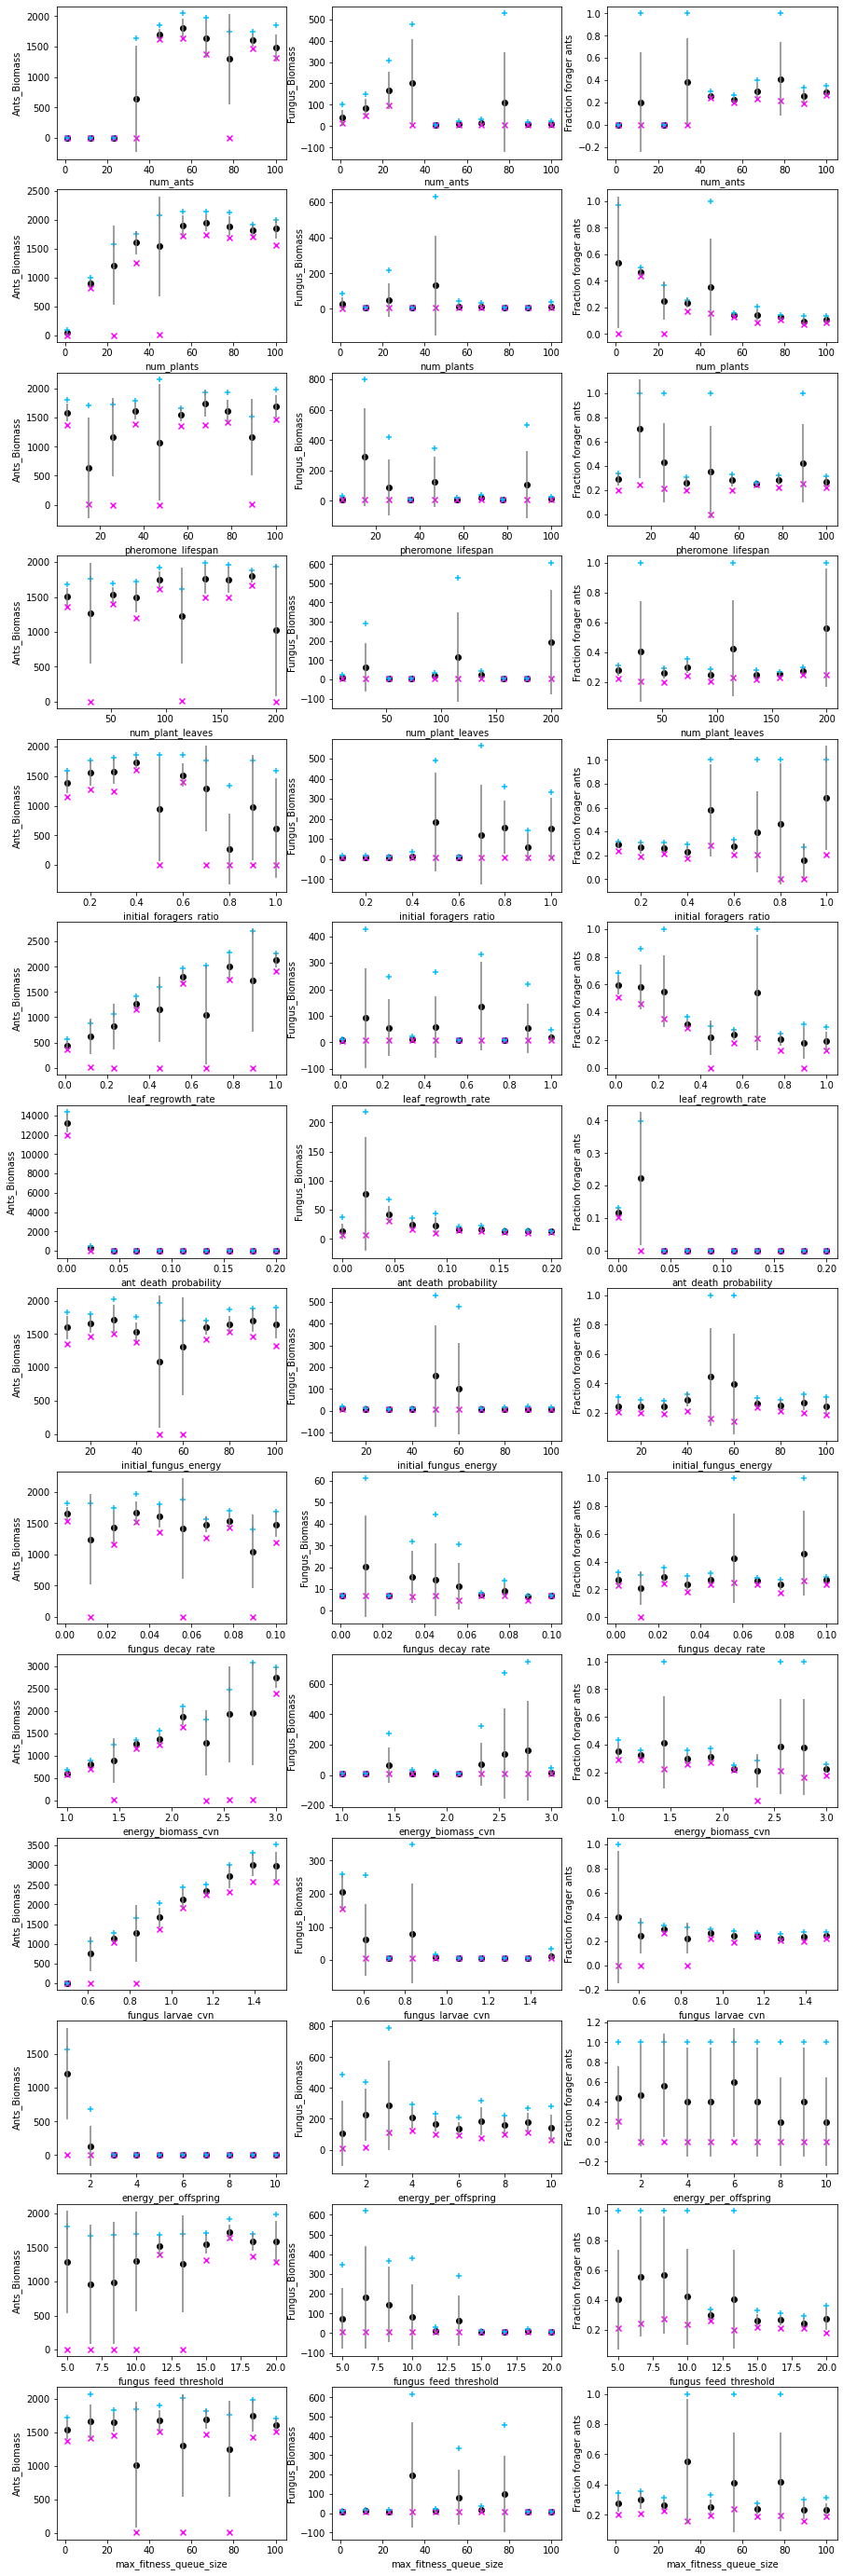

In [78]:
data = dict(np.load('Data/SA-experimentation250122.npz', allow_pickle=True))['arr_0'][()]

problem = {'num_ants': [int, [1,100]],
           'num_plants': [int, [1,100]], 
           'pheromone_lifespan': [int, [5, 100]],
           'num_plant_leaves': [int, [10, 200]],
           'initial_foragers_ratio': [float, [0.1, 1.0]], 
           'leaf_regrowth_rate': [float, [0.01, 1.0]],
           'ant_death_probability': [float, [0, 0.2]],
           'initial_fungus_energy': [float, [10, 100]],
           'fungus_decay_rate': [float, [0.001, 0.1]], 
           'energy_biomass_cvn': [float, [1, 3]], 
           'fungus_larvae_cvn': [float, [0.5, 1.5]],
           'energy_per_offspring': [float, [1.0, 10]],
           'fungus_feed_threshold': [float, [5.0, 20.0]],
           'max_fitness_queue_size': [int, [1, 100]],
}
           
model_reporters = {"Ants_Biomass": track_ants,
                "Fungus_Biomass": lambda m: m.fungus.biomass,
                "Fraction forager ants": track_ratio_foragers,
}

plot_all_vars(data, model_reporters)

In [33]:
print(data.keys())
df = data['num_ants']
print(df.head(10))
print(df[df['num_ants'] == 100])

dict_keys(['num_ants', 'num_plants', 'pheromone_lifespan', 'num_plant_leaves', 'initial_foragers_ratio', 'leaf_regrowth_rate', 'ant_death_probability', 'initial_fungus_energy', 'fungus_decay_rate', 'energy_biomass_cvn', 'fungus_larvae_cvn', 'energy_per_offspring', 'fungus_feed_threshold', 'max_fitness_queue_size'])
    num_ants  Run  Ants_Biomass  Fraction forager ants  Fungus_Biomass
0          1    0             0               0.000000       12.335191
22        45    0          1641               0.249848        6.984095
20        56    0          1643               0.201461        6.925032
32        67    0          1978               0.229019        6.994905
14        34    0             0               0.000000      205.441348
11        23    0             0               0.000000      159.234934
37        89    0          1568               0.190689        6.926601
36        78    0          1749               0.240137        6.972043
48       100    0          1512             

In [24]:
# np.savez('Data/SA-experimentation250122', data)